<a href="https://colab.research.google.com/github/VipinBioLab/3rd-place-kaggle-siim-isic-melanoma-classification/blob/master/Modified%20EfficientNetV2-Small%2BSVM%20classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers,Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Attention
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, accuracy_score
import matplotlib.pyplot as plt

In [ ]:
# Import the Desired Version of EfficientNet
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2S, preprocess_input, decode_predictions
from google.colab.patches import cv2_imshow
import pandas as pd
import numpy as np
import seaborn as sns
import imutils
import time
import cv2

In [ ]:
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
base_dir = '/content/drive/MyDrive/APTOS 2019 dataset'
train_dir = os.path.join(base_dir, 'train_images/train_images/')
validation_dir = os.path.join(base_dir, 'val_images/val_images/')
test_dir = os.path.join(base_dir, 'test_images/test_images/')

In [ ]:
print(os.listdir(train_dir))
print(os.listdir(validation_dir))
print(os.listdir(test_dir))

['a26f50218b84.png', 'a2811f512c1c.png', 'a247961a5cd9.png', 'a2ad3da4c7d6.png', 'a2696f444ecb.png', 'a1edf0e66592.png', 'a21b37719f9b.png', 'a2163f0c2af5.png', 'a1eb88562239.png', 'a1b12fdce6c3.png', 'a1e236fbc863.png', 'a28bfb772f50.png', 'a19ecd0a706e.png', 'a1faeb4d5f10.png', 'a1b28bcbce00.png', 'a32b5ce3d48a.png', 'a2ddabee14e9.png', 'a3132c8828e4.png', 'a32886cb31ab.png', 'a2dff8dbc9f8.png', 'a34fc5376669.png', 'a30a143a53a3.png', 'a2b995b81692.png', 'a2d349f567a6.png', 'a2b97d98f130.png', 'a3475dc3ac80.png', 'a3706ce27869.png', 'a3ad6c2db6f1.png', 'a3b2e93d058b.png', 'a3bd2e034614.png', 'a3fcf42ff56d.png', 'a3957df90a78.png', 'a4012932e18d.png', 'a386ec9aabde.png', 'a384e688e228.png', 'a3802934bad7.png', 'a3d2a0c4cd17.png', 'a419fcb2dfb5.png', 'a44345b27804.png', 'a443c4fd489c.png', 'a45d77edf8d9.png', 'a47878630dc2.png', 'a476fd984005.png', 'a4359815f152.png', 'a45c30da0c72.png', 'a47432cd41e7.png', 'a4d4b69f7404.png', 'a528be013a04.png', 'a505981d1cab.png', 'a484bdf85b4c.png',

In [ ]:
train_path = "/content/drive/MyDrive/APTOS 2019 dataset/train_images/train_images/"
valid_path = "/content/drive/MyDrive/APTOS 2019 dataset/val_images/val_images/"
test_path = "/content/drive/MyDrive/APTOS 2019 dataset/test_images/test_images/"

In [ ]:
NUM_CLASSES = 2

In [ ]:
# epochs = 20
# model_save_location = "/content/drive/MyDrive/APTOS 2019 dataset/1) Normal softmax classification and SVM classification - 2nd try without dropout"

In [ ]:
img_augmentation = Sequential(
    [
        preprocessing.RandomRotation(factor=0.15),
        preprocessing.RandomTranslation(height_factor=0.1, width_factor=0.1),
        preprocessing.RandomFlip(),
        preprocessing.RandomContrast(factor=0.1),
    ],
    name="img_augmentation",
)

In [ ]:
# @title SVM_without_attention
def build_model_SVM_without_attention(NUM_CLASSES):
    inputs = layers.Input(shape=(224, 224, 3))
    x = img_augmentation(inputs)

    #Using the imported version of EfficientNet
    model = EfficientNetV2S(include_top=False, input_tensor=x, weights="imagenet")

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    outputs = layers.Dense(NUM_CLASSES, activation="softmax", name="pred")(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name="EfficientNetV2S_without_SVM_Attention")
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
    return model

In [ ]:
def unfreeze_model(model):
    # We unfreeze the top 10 layers while leaving BatchNorm layers frozen
    for layer in model.layers[-10:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )

In [ ]:
def test_model(model,test_batches):
    #Testing the Model
    test_labels = test_batches.classes
    print("Test Labels",test_labels)
    print(test_batches.class_indices)

    predictions = model.predict(test_batches,steps=len(test_batches),verbose=0)

    acc = 0
    for i in range(len(test_labels)):
        actual_class = test_labels[i]
        if predictions[i][actual_class] > 0.5 :
            acc += 1
    print("Accuarcy:",(acc/len(test_labels))*100,"%")

In [ ]:
def load_data():
    train = pd.read_csv('/content/drive/MyDrive/APTOS 2019 dataset/train_1 - 2 class.csv',encoding='utf-8')
    test = pd.read_csv('/content/drive/MyDrive/APTOS 2019 dataset/test - 2 class.csv',encoding='utf-8')
    valid = pd.read_csv('/content/drive/MyDrive/APTOS 2019 dataset/val - 2 class.csv',encoding='utf-8')

    train_dir = os.path.join('/content/drive/MyDrive/APTOS 2019 dataset/train_images/train_images')
    test_dir = os.path.join('/content/drive/MyDrive/APTOS 2019 dataset/test_images/test_images')
    valid_dir = os.path.join('/content/drive/MyDrive/APTOS 2019 dataset/val_images/val_images')

    # Construct file paths directly within function:
    train['file_path'] = [os.path.join(train_dir, f'{id_code}.png') for id_code in train['id_code']]
    test['file_path'] = [os.path.join(test_dir, f'{id_code}.png') for id_code in test['id_code']]
    valid['file_path'] = [os.path.join(valid_dir, f'{id_code}.png') for id_code in valid['id_code']]

    # Construct file names using list comprehensions:
    train['train_images'] = [id_code + ".png" for id_code in train["id_code"]]
    test['test_images'] = [id_code + ".png" for id_code in test["id_code"]]
    valid['val_images'] = [id_code + ".png" for id_code in valid["id_code"]]

    train['diagnosis'] = train['diagnosis'].astype(str)
    test['diagnosis'] = test['diagnosis'].astype(str)
    valid['diagnosis'] = valid['diagnosis'].astype(str)

    return train, test, valid

In [ ]:
def preprocess_image(img_path):
  img = load_img(img_path, target_size=(224, 224))
  img_array = img_to_array(img)
  img_array = np.expand_dims(img_array, axis=0)
  return preprocess_input(img_array)

In [ ]:
def compute_gradcam(model, img_array, last_conv_layer_name, class_idx):
    grad_model = Model(
        inputs=[model.inputs],
        outputs=[model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array,training=False)
        class_channel = preds[:, class_idx]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [ ]:
def display_heatmap(original_img, heatmap, alpha=0.5):
    img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    superimposed_img = heatmap * alpha + img
    superimposed_img = np.uint8(superimposed_img)

    plt.figure(figsize=(5, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(superimposed_img)
    plt.title('Grad-CAM Heatmap')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
if __name__ == "__main__":
    train_df, test_df, valid_df = load_data()
    model = build_model_SVM_without_attention(NUM_CLASSES)
    unfreeze_model(model)

    train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.efficientnet_v2.preprocess_input).flow_from_dataframe(
        dataframe=train_df, x_col='file_path', y_col='diagnosis', target_size=(224,224), batch_size=32)
    valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.efficientnet_v2.preprocess_input).flow_from_dataframe(
        dataframe=valid_df, x_col='file_path', y_col='diagnosis', target_size=(224,224), batch_size=32)
    test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.efficientnet_v2.preprocess_input).flow_from_dataframe(
        dataframe=test_df, x_col='file_path', y_col='diagnosis', target_size=(224,224), batch_size=32, shuffle=False)

    # trained_model_path = '/content/drive/MyDrive/APTOS 2019 dataset/1) Normal softmax and SVM classification and intermediate features - 1st try'
    # model = tf.keras.models.load_model(trained_model_path)
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-3)
    history = model.fit(train_batches, epochs=epochs, validation_data=valid_batches, verbose=1,callbacks=[early_stopping,reduce_lr])

Found 2930 validated image filenames belonging to 2 classes.
Found 366 validated image filenames belonging to 2 classes.
Found 366 validated image filenames belonging to 2 classes.


In [ ]:
# for i in range(len(test_df)):
#   img_path = test_df['file_path'][i]
#   original_img = cv2.imread(img_path)
#   img_array = preprocess_image(img_path)
#   predicted_label = model.predict(img_array)
#   predicted_label = np.argmax(predicted_label)
#   last_conv_layer_name = "top_activation"  # Replace with the actual last conv layer name of your model
#   class_idx = predicted_label  # Replace with the actual class index you want to visualize
#   actual_label = test_df['diagnosis'][i]
#   print(i,actual_label, predicted_label)

In [ ]:
def display_heatmap1(heatmap):
    # Resize the heatmap to a higher resolution
    heatmap_resized = cv2.resize(heatmap, (224, 224))  # Adjust the size as needed
    # Display the heatmap with improved granularity
    plt.imshow(heatmap_resized, cmap='jet', interpolation='bilinear')
    plt.colorbar()
    plt.show()

- 0,1 - 100,166,253,287,354
- 1,0 - 60,76,141,329,339
- 0,0 - 4,40,93,154,202
- 1,1 - 9,33,149,268,352

1/1 [==============================] - 0s 437ms/step
1 1


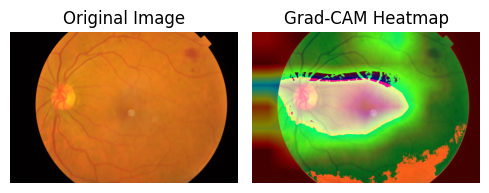

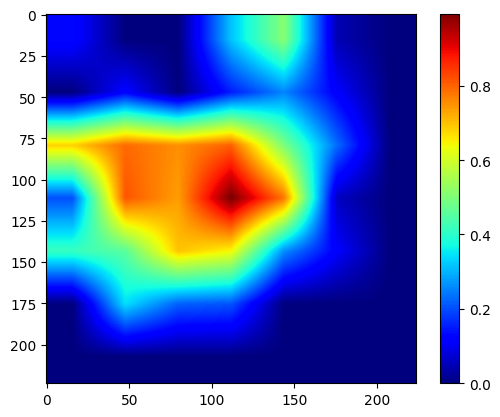

In [ ]:
index = 352
img_path = test_df['file_path'][index]
original_img = cv2.imread(img_path)
img_array = preprocess_image(img_path)
predicted_label = model.predict(img_array)
predicted_label = np.argmax(predicted_label)
last_conv_layer_name = "top_conv"  # Replace with the actual last conv layer name of your model
actual_label = test_df['diagnosis'][index]
class_idx = predicted_label  # Replace with the actual class index you want to visualize
print(actual_label, predicted_label)
heatmap = compute_gradcam(model, img_array, last_conv_layer_name, class_idx)
display_heatmap(original_img, heatmap)
display_heatmap1(heatmap)

In [ ]:
# predicted_label = model.predict(img_array)
# predicted_label = np.argmax(predicted_label)
# actual_label = test_df['diagnosis'][2]  # Assuming 'diagnosis' contains the actual labels

In [ ]:
# # Save the tensorflow Model
# model.save(model_save_location)

In [ ]:
model.summary()

Model: "EfficientNetV2S_without_SVM_Attention"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 img_augmentation (Sequenti  (None, None, None, None)     0         ['input_3[0][0]']             
 al)                                                                                              
                                                                                                  
 rescaling_2 (Rescaling)     (None, 224, 224, 3)          0         ['img_augmentation[0][0]']    
                                                                                                  
 stem_conv (Conv2D)          (None, 112, 112, 24)         648 

In [ ]:
model.summary()  #1st try

Model: "EfficientNetV2S_with_SVM_Attention"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 img_augmentation (Sequenti  (None, None, None, None)     0         ['input_1[0][0]']             
 al)                                                                                              
                                                                                                  
 rescaling (Rescaling)       (None, 224, 224, 3)          0         ['img_augmentation[0][0]']    
                                                                                                  
 stem_conv (Conv2D)          (None, 112, 112, 24)         648    

In [ ]:
#Testing the Model
test_model(model,test_batches)

Test Labels [0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 

In [ ]:
softmax_pred = (model.predict(test_batches) > 0.5).astype("int32")

12/12 [==============================] - 91s 7s/step


In [ ]:
softmax_pred

array([[1, 0],
       [0, 1],
       [0, 1],
       [0, 1],
       [1, 0],
       [1, 0],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [1, 0],
       [1, 0],
       [0, 1],
       [1, 0],
       [0, 1],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [0, 1],
       [1, 0],
       [1, 0],
       [0, 1],
       [0, 1],
       [0, 1],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [0, 1],
       [1, 0],
       [0, 1],
       [0, 1],
       [0, 1],
       [1, 0],
       [0, 1],
       [0, 1],
       [1, 0],
       [0, 1],
       [1, 0],
       [1, 0],
       [0, 1],
       [0, 1],
       [1, 0],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [1, 0],
       [0, 1],
       [1, 0],
       [0, 1],
       [0, 1],
       [0, 1],
       [1, 0],
       [0, 1],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [0, 1],
       [1, 0],
       [0, 1],
       [0, 1],
       [1, 0],
       [1,

In [ ]:
# Classification report
print("Classification Report:\n", classification_report(test_batches.labels, softmax_pred.argmax(axis=1)))

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.95      0.96       199
           1       0.94      0.97      0.96       167

    accuracy                           0.96       366
   macro avg       0.96      0.96      0.96       366
weighted avg       0.96      0.96      0.96       366



Text(0.5, 1.0, 'Confusion Matrix')

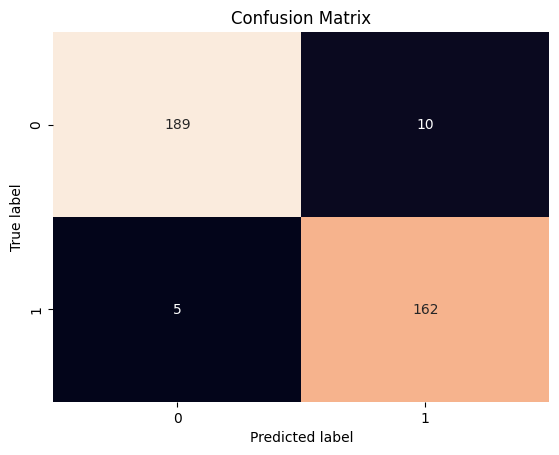

In [ ]:
cms = confusion_matrix(test_batches.labels, softmax_pred.argmax(axis=1))  #top_dropout softmax
sns.heatmap(cms, annot=True, cbar=False, fmt='d')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')

In [ ]:
print("Confusion Matrix:\n", confusion_matrix(test_batches.labels, softmax_pred.argmax(axis=1)))

Confusion Matrix:
 [[189  10]
 [  5 162]]


In [ ]:
# Collect data from the generator
X_train, y_train = [], []
for _ in range(len(train_batches)):
    images, labels = train_batches.next()
    X_train.append(images)
    y_train.append(labels)

In [ ]:
# Convert lists to arrays
X_train = np.vstack(X_train)
y_train = np.vstack(y_train)

In [ ]:
# Reshape X_train to be 2D (necessary for SVM)
X_train1 = X_train.reshape(X_train.shape[0], -1)

In [ ]:
X_train1.shape

(2930, 150528)

In [ ]:
y_train

In [ ]:
# Collect data from the generator
X_test, y_test = [], []
for _ in range(len(test_batches)):
    images, labels = test_batches.next()
    X_test.append(images)
    y_test.append(labels)

In [ ]:
# Convert lists to arrays
X_test = np.vstack(X_test)
y_test = np.vstack(y_test)

In [ ]:
# Reshape X_train to be 2D (necessary for SVM)
X_test1 = X_test.reshape(X_test.shape[0], -1)

In [ ]:
X_test1.shape

(366, 150528)

In [ ]:
y_test

In [ ]:
# Initialize and train the SVC with verbose output
start = time.time()
svc = SVC(verbose=True,kernel='rbf')
svc.fit(X_train1, y_train.argmax(axis=1))  # Use argmax to get class indices if y_train is one-hot encoded
print('Running time: %.4f seconds' % (time.time()-start))

[LibSVM]Running time: 457.6672 seconds


In [ ]:
# Get predictions from SVC using test features
predictions_test = svc.predict(X_test1)

In [ ]:
# Calculate accuracy
accuracy_test = accuracy_score(y_test.argmax(axis=1), predictions_test)
print("Testing Accuracy using SVM with Feature Extraction:", accuracy_test)

Testing Accuracy using SVM with Feature Extraction: 0.9480874316939891


In [ ]:
print(classification_report(test_batches.labels, predictions_test))

              precision    recall  f1-score   support

           0       0.97      0.93      0.95       199
           1       0.93      0.96      0.94       167

    accuracy                           0.95       366
   macro avg       0.95      0.95      0.95       366
weighted avg       0.95      0.95      0.95       366



Text(0.5, 1.0, 'Confusion Matrix')

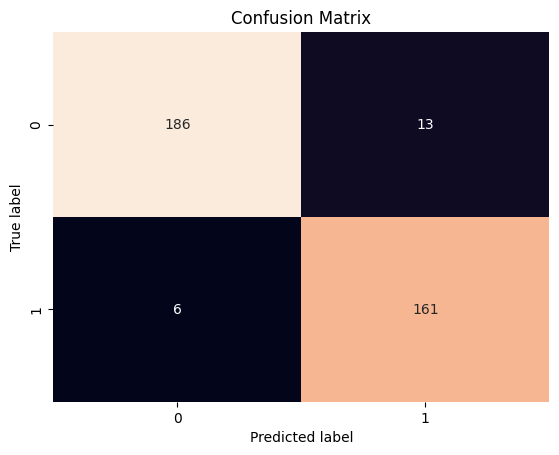

In [ ]:
cmsvm = confusion_matrix(test_batches.labels, predictions_test)  #batch_normalization
sns.heatmap(cmsvm, annot=True, cbar=False, fmt='d')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')

In [ ]:
from tensorflow.python.keras.models import Model

In [ ]:
model1 = tf.keras.Model(inputs=model.input, outputs=model.get_layer('top_dropout').output)

In [ ]:
features_array_train1 = model1.predict(X_train)

92/92 [==============================] - 567s 6s/step


In [ ]:
features_array_train1.shape

(2930, 1280)

In [ ]:
features_array_test1 = model1.predict(X_test)

12/12 [==============================] - 59s 5s/step


In [ ]:
features_array_test1.shape

(366, 1280)

In [ ]:
import time
start = time.time()

from sklearn.svm import SVC
clf = SVC()
clf.fit(features_array_train1, y_train.argmax(axis=1))
preds1 = clf.predict(features_array_test1)

print('Running time: %.4f seconds' % (time.time()-start))

Running time: 1.3790 seconds


In [ ]:
print(accuracy_score(y_test.argmax(axis=1), preds1))  #top_dropout

0.9726775956284153


In [ ]:
print(accuracy_score(y_test.argmax(axis=1), preds1))  #batch_normalization

In [ ]:
print(accuracy_score(y_test.argmax(axis=1), preds1))  #batch_normalization without dropout

0.9699453551912568


In [ ]:
cm = confusion_matrix(test_batches.labels, preds1)  #top_dropout
sns.heatmap(cm, annot=True, cbar=False, fmt='d')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')

Text(0.5, 1.0, 'Confusion Matrix')

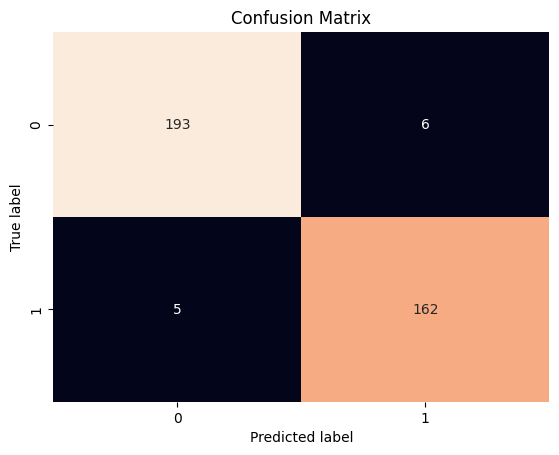

In [ ]:
cm = confusion_matrix(test_batches.labels, preds1)  #batch_normalization
sns.heatmap(cm, annot=True, cbar=False, fmt='d')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')

Text(0.5, 1.0, 'Confusion Matrix')

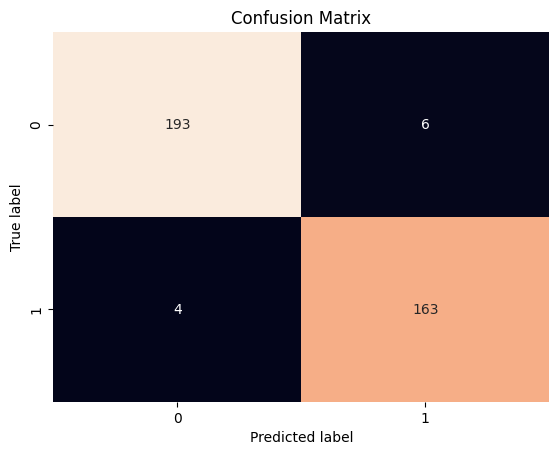

In [ ]:
cm = confusion_matrix(test_batches.labels, preds1)  #top_dropout
sns.heatmap(cm, annot=True, cbar=False, fmt='d')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')

In [ ]:
print(classification_report(test_batches.labels, preds1))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97       199
           1       0.96      0.97      0.97       167

    accuracy                           0.97       366
   macro avg       0.97      0.97      0.97       366
weighted avg       0.97      0.97      0.97       366



In [ ]:
print(classification_report(test_batches.labels, preds1)) # top_dropout 1st try

              precision    recall  f1-score   support

           0       0.98      0.97      0.97       199
           1       0.96      0.98      0.97       167

    accuracy                           0.97       366
   macro avg       0.97      0.97      0.97       366
weighted avg       0.97      0.97      0.97       366



## Visual metrics

In [ ]:
# Assuming the model is trained and model.history contains the training history
def plot_accuracy_loss(history):
    # Accuracy plot
    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')

    plt.show()

In [ ]:
# Assuming `history` is the history object returned by model.fit()
plot_accuracy_loss(history)

In [ ]:
def plot_roc_curve(y_true, y_pred_proba):
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='red', lw=2, label='ROC curve (area = %0.5f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

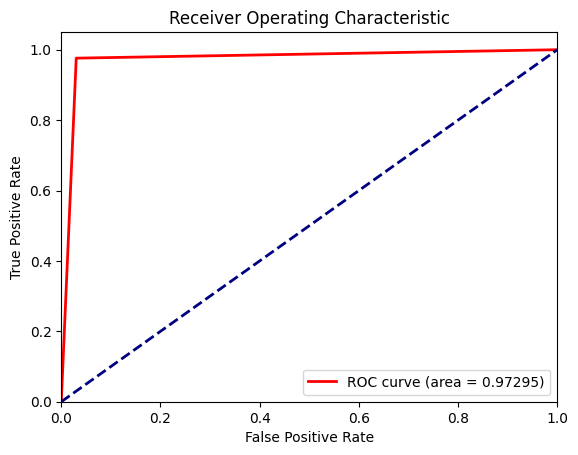

In [ ]:
# Assuming y_pred_proba are the predicted probabilities
plot_roc_curve(test_batches.labels, preds1)  #top_dropout EffNetV2-SVC

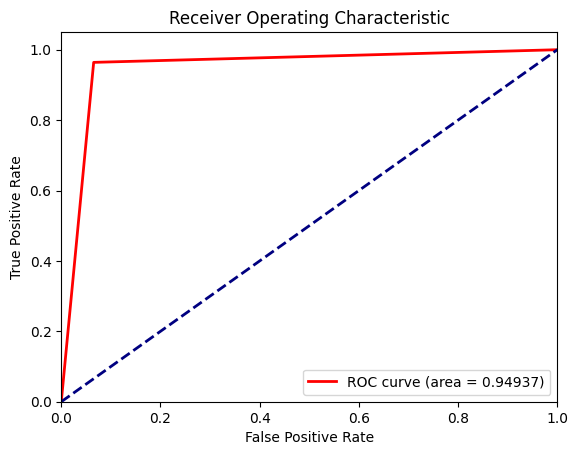

In [ ]:
# Assuming y_pred_proba are the predicted probabilities
plot_roc_curve(test_batches.labels, predictions_test)  #SVM

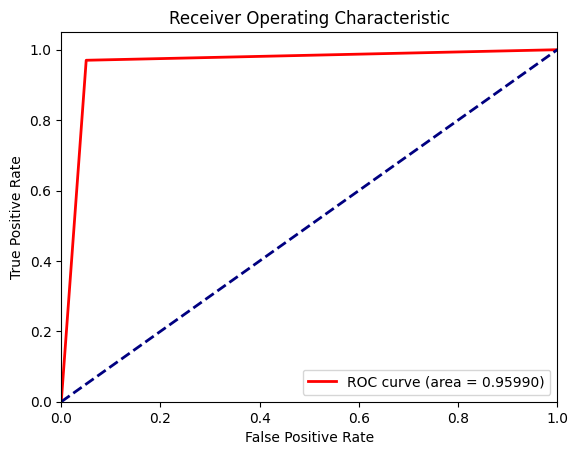

In [ ]:
# Assuming y_pred_proba are the predicted probabilities
plot_roc_curve(test_batches.labels, softmax_pred.argmax(axis=1))  #softmax

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def plot_roc_curves(y_true, y_pred_probas, labels):
    plt.figure()
    for i in range(len(y_pred_probas)):
        fpr, tpr, _ = roc_curve(y_true, y_pred_probas[i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'{labels[i]} (area = {roc_auc:.5f})')

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.show()

In [ ]:
preds1

array([0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1,
       0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0,
       0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0,
       1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1,
       1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0,
       0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0,

In [ ]:
softmax_pred.argmax(axis=1)

array([0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1,
       0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0,
       0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0,
       0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0,
       1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1,
       1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0,
       0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0,

In [ ]:
test_batches.labels

[0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,


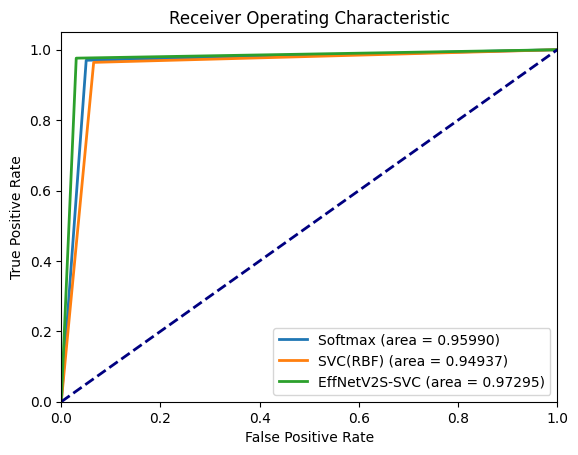

In [ ]:
# Example usage
y_true2 = test_batches.labels
y_pred_probas = [softmax_pred.argmax(axis=1),
    predictions_test,
    preds1]
labels = ['Softmax', 'SVC(RBF)', 'EffNetV2S-SVC']

plot_roc_curves(y_true2, y_pred_probas, labels)

In [ ]:
def plot_precision_recall_curve(y_true, y_pred_proba):
    precision, recall, _ = precision_recall_curve(y_true, y_pred_proba)

    plt.figure()
    plt.plot(recall, precision, color='blue')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.show()

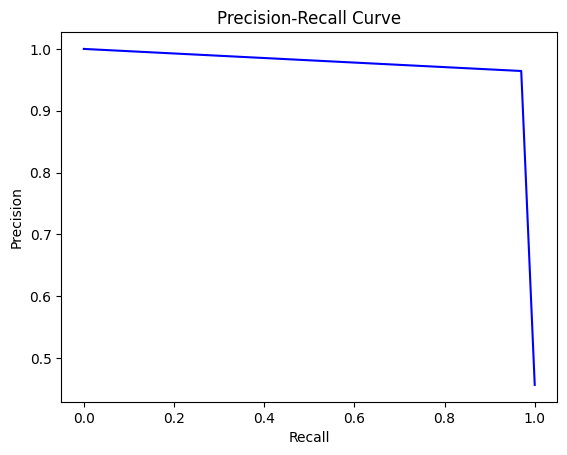

In [ ]:
plot_precision_recall_curve(y_test.argmax(axis=1), preds1)

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc

def plot_precision_recall_curves(y_true, y_pred_probas, labels):
    plt.figure()
    for i in range(len(y_pred_probas)):
        precision, recall, _ = precision_recall_curve(y_true, y_pred_probas[i])
        pr_auc = auc(recall, precision)
        plt.plot(recall, precision, lw=2, label=f'{labels[i]} (area = {pr_auc:.5f})')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='best')
    plt.show()

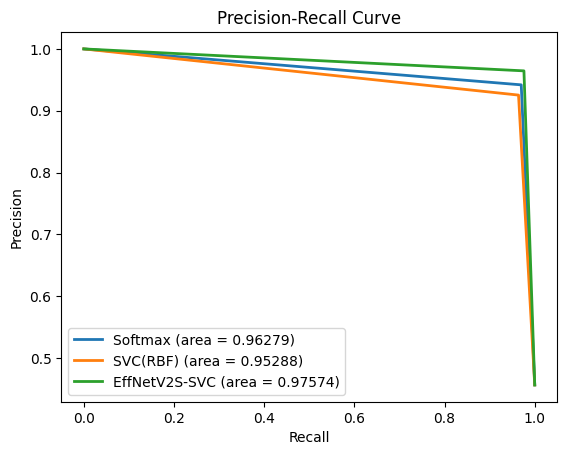

In [ ]:
# Example usage
y_true2 = test_batches.labels
y_pred_probas = [softmax_pred.argmax(axis=1),
    predictions_test,
    preds1]
labels = ['Softmax', 'SVC(RBF)', 'EffNetV2S-SVC']

plot_precision_recall_curves(y_true2, y_pred_probas, labels)

In [ ]:
from sklearn.calibration import calibration_curve

In [ ]:
def plot_calibration_curve(y_true, y_pred_proba):
    prob_true, prob_pred = calibration_curve(y_true, y_pred_proba, n_bins=10)

    plt.figure()
    plt.plot(prob_pred, prob_true, marker='o', linestyle='-', color='b')
    plt.plot([0, 1], [0, 1], linestyle='--', color='k')
    plt.xlabel('Mean predicted probability')
    plt.ylabel('Fraction of positives')
    plt.title('Calibration Curve')
    plt.show()

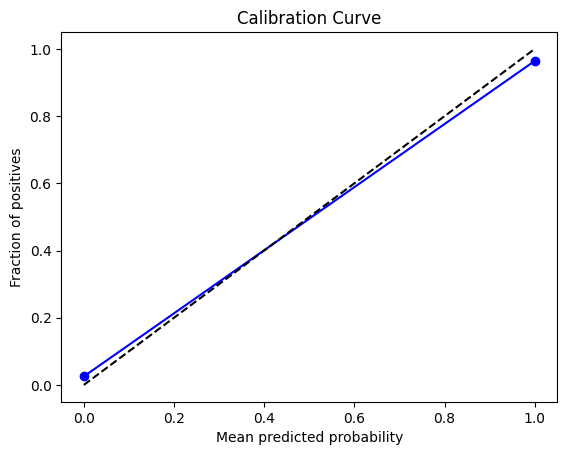

In [ ]:
plot_calibration_curve(y_test.argmax(axis=1), preds1)

In [ ]:
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve

def plot_calibration_curves(y_true, y_pred_probas, labels):
    plt.figure()
    for i in range(len(y_pred_probas)):
        prob_true, prob_pred = calibration_curve(y_true, y_pred_probas[i], n_bins=10)
        plt.plot(prob_pred, prob_true, marker='o', label=labels[i])

    plt.plot([0, 1], [0, 1], linestyle='--', color='black')
    plt.xlabel('Predicted Probabilities')
    plt.ylabel('True Probabilities')
    plt.title('Calibration Curves')
    plt.legend(loc='best')
    plt.show()

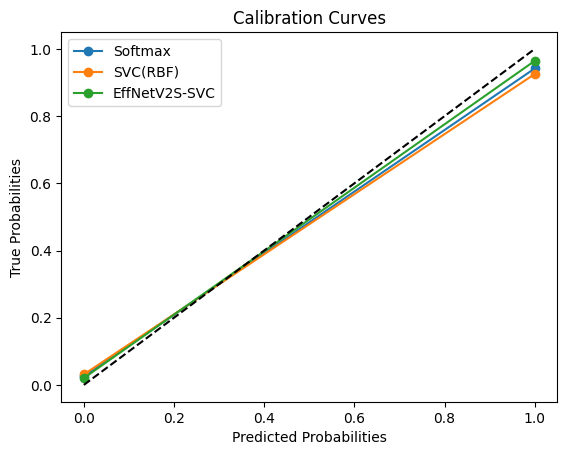

In [ ]:
# Example usage
y_true2 = test_batches.labels
y_pred_probas = [softmax_pred.argmax(axis=1),
    predictions_test,
    preds1]
labels = ['Softmax', 'SVC(RBF)', 'EffNetV2S-SVC']

plot_calibration_curves(y_true2, y_pred_probas, labels)

## End of visual metrics